Epoch 1/100
221/221 - 2s - loss: 0.0114 - 2s/epoch - 9ms/step
Epoch 2/100
221/221 - 0s - loss: 0.0073 - 338ms/epoch - 2ms/step
Epoch 3/100
221/221 - 0s - loss: 0.0067 - 332ms/epoch - 2ms/step
Epoch 4/100
221/221 - 0s - loss: 0.0066 - 376ms/epoch - 2ms/step
Epoch 5/100
221/221 - 0s - loss: 0.0058 - 321ms/epoch - 1ms/step
Epoch 6/100
221/221 - 0s - loss: 0.0058 - 315ms/epoch - 1ms/step
Epoch 7/100
221/221 - 0s - loss: 0.0057 - 314ms/epoch - 1ms/step
Epoch 8/100
221/221 - 0s - loss: 0.0055 - 323ms/epoch - 1ms/step
Epoch 9/100
221/221 - 0s - loss: 0.0056 - 331ms/epoch - 1ms/step
Epoch 10/100
221/221 - 0s - loss: 0.0056 - 368ms/epoch - 2ms/step
Epoch 11/100
221/221 - 0s - loss: 0.0055 - 342ms/epoch - 2ms/step
Epoch 12/100
221/221 - 0s - loss: 0.0052 - 368ms/epoch - 2ms/step
Epoch 13/100
221/221 - 0s - loss: 0.0057 - 339ms/epoch - 2ms/step
Epoch 14/100
221/221 - 0s - loss: 0.0054 - 322ms/epoch - 1ms/step
Epoch 15/100
221/221 - 0s - loss: 0.0056 - 352ms/epoch - 2ms/step
Epoch 16/100
221/221 -

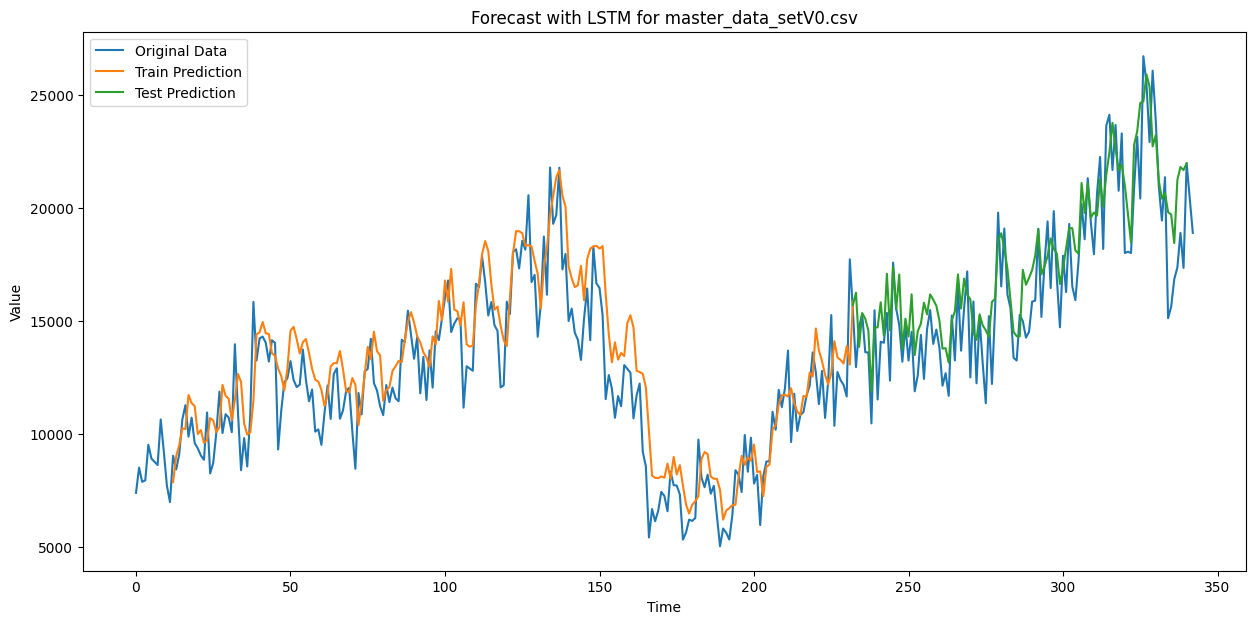

1/1 [==============================] - 0s 19ms/step


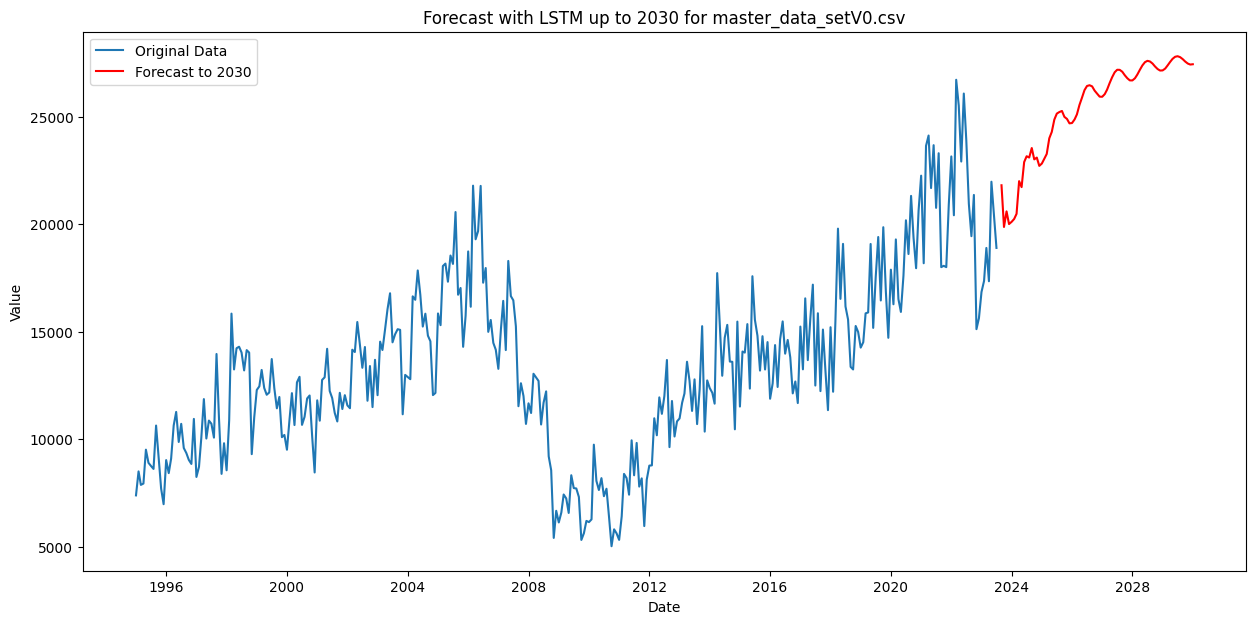

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load and preprocess data
dataframe_names = ['master_data_setV0.csv']  # Add your CSV file names here

for file_name in dataframe_names:
    df = pd.read_csv(file_name)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df[df['State'] == 'Texas']  # Filtering by state
    df = df.drop(columns=['State', 'Division'])  # Dropping unnecessary columns
    
#     # Limit the dataset to end in 2019
#     df = df[df.index.year <= 2019]

    # Assuming 'Value' is the target variable
    y = df['Value'].values.reshape(-1, 1)

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    y_scaled = scaler.fit_transform(y)

    # Function to create a dataset for LSTM
    def create_dataset(data, look_back=1):
        X, Y = [], []
        for i in range(len(data) - look_back - 1):
            a = data[i:(i + look_back), 0]
            X.append(a)
            Y.append(data[i + look_back, 0])
        return np.array(X), np.array(Y)

    look_back = 12
    X, Y = create_dataset(y_scaled, look_back)

    # Split into train and test sets
    train_size = int(len(X) * 0.67)
    test_size = len(X) - train_size
    trainX, trainY = X[:train_size], Y[:train_size]
    testX, testY = X[train_size:], Y[train_size:]

    # Reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

    # Make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # Invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

    # Calculate RMSE
    trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
    print(f'Train Score: {trainScore:.2f} RMSE')
    testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
    print(f'Test Score: {testScore:.2f} RMSE')

    # Calculate the number of data points used in training and testing
    train_size = len(trainX)
    test_size = len(testX)

    # Initialize the plotting arrays
    trainPredictPlot = np.empty_like(y_scaled)
    trainPredictPlot[:, :] = np.nan
    testPredictPlot = np.empty_like(y_scaled)
    testPredictPlot[:, :] = np.nan

    # Insert the training predictions
    trainPredictPlot[look_back:train_size + look_back, :] = trainPredict

    # Calculate the start and end indices for the test predictions in the plot
#     test_start_index = train_size + (look_back * 2) - 1
    test_start_index = train_size + (look_back) - 1
    test_end_index = test_start_index + test_size

    # Ensure the test predictions fit within the testPredictPlot array
    testPredictPlot[test_start_index:test_end_index, :] = testPredict

    # Plot baseline and predictions
    plt.figure(figsize=(15, 7))
    plt.plot(scaler.inverse_transform(y_scaled), label='Original Data')
    plt.plot(trainPredictPlot, label='Train Prediction')
    plt.plot(testPredictPlot, label='Test Prediction')
    plt.title(f'Forecast with LSTM for {file_name}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # Forecasting out to 2030
    last_date = df.index[-1]
    months_to_predict = (2030 - last_date.year) * 12 - last_date.month

    # Start with the last `look_back` months from the original dataset
    input_seq = y_scaled[-look_back:]

    # Store the forecasts
    forecasts = []

    # Iteratively predict each future month
    for _ in range(months_to_predict):
        # Reshape input_seq to the format required by the LSTM model
        lstm_input = np.reshape(input_seq, (1, 1, look_back))

        # Predict the next step
        predicted_step = model.predict(lstm_input)

        # Append the prediction to forecasts
        forecasts.append(predicted_step[0, 0])

        # Update the input sequence for the next prediction
        input_seq = np.append(input_seq[1:], predicted_step)

    # Transform forecasts back to the original scale
    forecasts = scaler.inverse_transform(np.array(forecasts).reshape(-1, 1))

    # Create a time series for the forecasts
    forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=months_to_predict, freq='M')
    forecast_series = pd.Series(data=forecasts.ravel(), index=forecast_dates)

    # Plot baseline, predictions, and future forecasts
    plt.figure(figsize=(15, 7))
    plt.plot(df.index, y, label='Original Data')
    plt.plot(forecast_series.index, forecast_series.values, label='Forecast to 2030', color='red')
    plt.title(f'Forecast with LSTM up to 2030 for {file_name}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
